# Dhh1p analysis

In [141]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr, spearmanr, ttest_ind, levene, f_oneway
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
import csv
import string
import warnings
warnings.filterwarnings('ignore')

sns.set(style="ticks", color_codes=True,font_scale=2)
snsRed, snsBlue, snsGreen, snsPurple, snsOrange = sns.color_palette("Set1", n_colors=5, desat=.5)

## 1. Load files

In [142]:
folder = "/seq/schatz/hfang/Projects/RiboSeq/Radhakrishnan_2016/new_te_analysis"

wt_rep1 = folder + "/SRR3493886/genesTE.csv"
wt_rep2 = folder + "/SRR3493887/genesTE.csv"
wt_rep1_riboseq_abundance = "../Data/Radhakrishnan/wt_riboseq_abundance.tsv"
codon_wt_rep1 = folder + "/SRR3493886/codons.csv"
codon_wt_rep2 = folder + "/SRR3493887/codons.csv"
Dhh1KO_rep1 = folder + "/SRR3493890/genesTE.csv"
Dhh1KO_rep2 = folder + "/SRR3493891/genesTE.csv"
codon_Dhh1KO_rep1 = folder + "/SRR3493890/codons.csv"
codon_Dhh1KO_rep2 = folder + "/SRR3493891/codons.csv"
Dhh1OE_rep1 = folder + "/SRR3493894/genesTE.csv"
Dhh1OE_rep2 = folder + "/SRR3493895/genesTE.csv"
codon_Dhh1OE_rep1 = folder + "/SRR3493894/codons.csv"
codon_Dhh1OE_rep2 = folder + "/SRR3493895/codons.csv"

original_fn = "/seq/schatz/hfang/Projects/RiboSeq/Radhakrishnan_2016/original_analysis/GSE81269_RPKM-All-Datasets.txt"
codon_weinberg = "../Data/skr_weinberg_codons.csv"
gene_tAI ="../Data/SacCer_stAIcalc_Sabi_Tuller.txt"
codon_stAI ="../Data/Yeast_codon_stAI.csv"
codon_tAI ="../Data/tAI.csv"

In [143]:
deltaTE_cutoff = 1

In [144]:
filesToLoad = [wt_rep1, wt_rep2, codon_wt_rep1, codon_wt_rep2, 
               Dhh1KO_rep1, Dhh1KO_rep2, codon_Dhh1KO_rep1, codon_Dhh1KO_rep2, 
               Dhh1OE_rep1, Dhh1OE_rep2, codon_Dhh1OE_rep1, codon_Dhh1OE_rep2,
               gene_tAI, codon_tAI, codon_weinberg, wt_rep1_riboseq_abundance]
DFs = {}
for f in filesToLoad:
    tmp_df = pd.read_table(f, header=0)
    DFs[f] = tmp_df

DFs[codon_stAI] = pd.read_table(codon_stAI, header=0, sep=",")

In [145]:
TePair = {"TE_WT":[wt_rep1, wt_rep2],
          "TE_KO":[Dhh1KO_rep1, Dhh1KO_rep2], 
          "TE_OE":[Dhh1OE_rep1, Dhh1OE_rep2]}
CodonPair = {"codon_WT":[codon_wt_rep1, codon_wt_rep2], 
             "codon_KO":[codon_Dhh1KO_rep1, codon_Dhh1KO_rep2],
             "codon_OE":[codon_Dhh1OE_rep1, codon_Dhh1OE_rep2]}

for k,v in TePair.items():
    DFs[k] = pd.merge(DFs[v[0]], DFs[v[1]], on="gene", suffixes=["_rep1","_rep2"])
    
for k,v in CodonPair.items():
    DFs[k] = pd.merge(DFs[v[0]], DFs[v[1]], on="codon", suffixes=["_rep1","_rep2"])

## 1. TE correlation between replicates

In [146]:
samples = ["WT", "KO", "OE"]

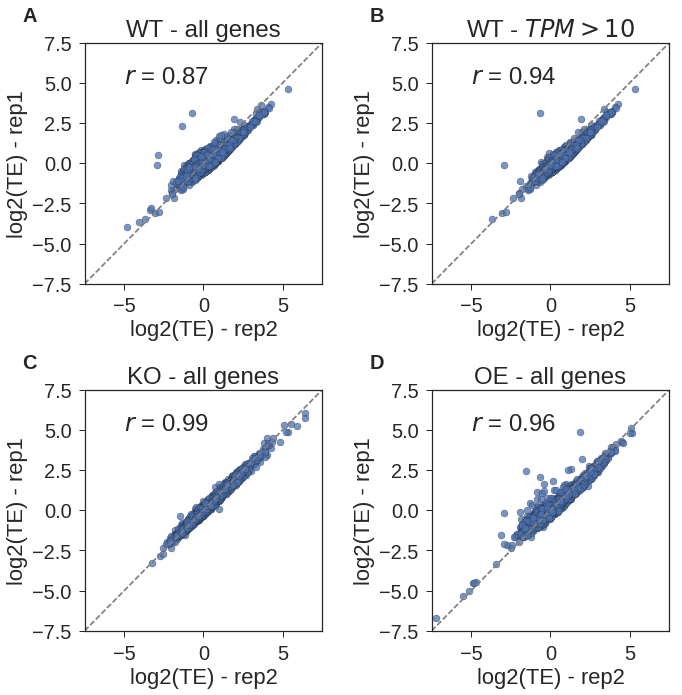

In [147]:
fig = plt.figure(figsize=(10, 10))

for i, label in enumerate(('A', 'B')):
    idx = i + 1
    sample = samples[0]
    if idx == 1:
        df = DFs["TE_" + sample] 
        title = sample + " - all genes" 
    else:
        df = pd.merge(DFs["TE_" + sample], DFs[wt_rep1_riboseq_abundance], left_on="gene", right_on="target_id")
        df = df[df["tpm"] > 10]
        title = sample + " - $TPM>10$" 
    corr = round(pearsonr(df["log2_TE_rep1"], df["log2_TE_rep2"])[0], 2)
    ax = plt.subplot(2, 2, idx)
    ax.scatter(x="log2_TE_rep1", y="log2_TE_rep2", data=df, alpha=0.75, edgecolor="k")
    plt.xlim(-7.5,7.5)
    plt.ylim(-7.5,7.5)
    ax.text(-5, 5, r"$r$ = " + str(corr))
    ax.text(-0.2, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.set_title(title)
    ax.set_ylabel('log2(TE) - rep1')
    ax.set_xlabel("log2(TE) - rep2")
    ax.plot([-7.5,7.5], [-7.5,7.5], ls="dashed", color='gray')

for i, label in enumerate(('C', 'D')):
    idx = i + 1
    sample=samples[idx]
    title = sample + " - all genes"
    df = DFs["TE_" + sample]
    corr = round(pearsonr(df["log2_TE_rep1"], df["log2_TE_rep2"])[0], 2)
    ax = plt.subplot(2, 2, idx+2)
    ax.scatter(x="log2_TE_rep1", y="log2_TE_rep2", data=df, alpha=0.75, edgecolor="k")
    plt.xlim(-7.5,7.5)
    plt.ylim(-7.5,7.5)
    ax.text(-5, 5, r"$r$ = " + str(corr))
    ax.text(-0.2, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.set_title(title)
    ax.set_ylabel('log2(TE) - rep1')
    ax.set_xlabel("log2(TE) - rep2")
    ax.plot([-7.5,7.5], [-7.5,7.5], ls="dashed", color='gray')

plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS7_TE_rep_corr.pdf")

## 2. codon elongation rate correlation between replicates

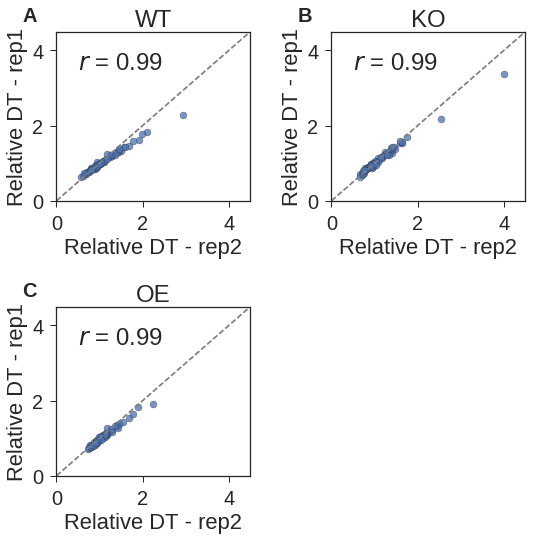

In [148]:
fig = plt.figure(figsize=(8, 8))

for i, label in enumerate(('A', 'B', 'C')):
    idx = i + 1
    sample=samples[i]
    title = sample + ""
    df = DFs["codon_" + sample]
    corr = round(pearsonr(df["codon_dwell_time_rep1"], df["codon_dwell_time_rep2"])[0], 2)
    ax = plt.subplot(2, 2, idx)
    ax.scatter(x="codon_dwell_time_rep1", y="codon_dwell_time_rep2", data=df, alpha=0.75, edgecolor="k")
    plt.xlim(0, 4.5)
    plt.ylim(0, 4.5)
    ax.text(0.5, 3.5, r"$r$ = " + str(corr))
    ax.text(-0.1, 1.15, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.set_title(title)
    ax.set_ylabel('Relative DT - rep1')
    ax.set_xlabel("Relative DT - rep2")
    ax.plot([0,5], [0,5], ls="dashed", color='gray')
    
plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS8_codon_rep_corr.pdf")

In [149]:
for sample in samples:
    df = DFs["codon_" + sample]
    DT_min, DT_max = np.min((df["codon_dwell_time_rep1"] + df["codon_dwell_time_rep2"])/2), np.max((df["codon_dwell_time_rep1"] + df["codon_dwell_time_rep2"])/2)
    DT_range = DT_max - DT_min
    DT_sd = np.std((df["codon_dwell_time_rep1"] + df["codon_dwell_time_rep2"])/2)
    print(sample)
    print("range:", round(DT_range,2))
    print("sd:", round(DT_sd,2))

WT
range: 2.01
sd: 0.36
KO
range: 3.05
sd: 0.45
OE
range: 1.35
sd: 0.27


## 3. Compare TE between conditions

### 0) Getting rpkm values from original paper.

In [150]:
original = pd.read_table(original_fn, header=0)
original = pd.merge(original, DFs[gene_tAI], left_on='Gene', right_on="genes_id")

original_map = {"WT_RNA_rep1":"IRWT", "WT_RNA_rep2":"RRWT",
                "WT_Ribo_rep1":"IPWT", "WT_Ribo_rep2":"RPWT",
                "KO_RNA_rep1":"IRDhKO", "KO_RNA_rep2":"RRDhKO",
                "KO_Ribo_rep1":"IPDhKO", "KO_Ribo_rep2":"RPDhKO",
                "OE_RNA_rep1":"IRDhOE", "OE_RNA_rep2":"RRDhOE",
                "OE_Ribo_rep1":"IPDhOE", "OE_Ribo_rep2":"RPDhOE"}
                                                      
for tpm, rpkm in original_map.items():
    original[tpm] = original[rpkm] * 1000000 / np.sum(original[rpkm])

for tpm in original_map.keys():
    original = original[original[tpm] > 0]
print(original.shape)

(5485, 34)


In [151]:
lst = ["WT_RNA", "WT_Ribo", "KO_RNA", "KO_Ribo", "OE_RNA", "OE_Ribo"]

for i in lst:
    original[i] = 1/2 * (original[i + "_rep1"] + original[i + "_rep2"])

original_Ribo_RNA_pairs = {"log2_TE_WT":["IRWT", ("IPWT", "RPWT")],
                           "log2_TE_OE":["IRDhOE", ("IPDhOE", "RPDhOE")],
                           "log2_TE_KO":["RRDhKO", ("IPDhKO", "RPDhKO")],
                          }

for k,v in original_Ribo_RNA_pairs.items():
    original[k + "_rep1"] = np.log2(original[v[1][0]] / original[v[0]])
    original[k + "_rep2"] = np.log2(original[v[1][1]] / original[v[0]])

for k,v in original_Ribo_RNA_pairs.items():
    original[k] = 1/2 * (original[k + "_rep1"] + original[k + "_rep2"])

### 1) Compare scikit-ribo & rpkm estimates

In [152]:
comparisons = [("KO", "WT"), ("OE", "WT"), ("OE", "KO")] 
prefixes = ["skr_", "rpkm_"]
strings = list(string.ascii_uppercase[:12])

In [153]:
# mean of replicates
for prefix in prefixes:
    for comparison in comparisons:
        l, r = comparison
        if prefix == "skr_":
            tmp = pd.merge(DFs["TE_" + l], DFs["TE_" + r], on='gene', suffixes=["_" + l, "_" + r])
            tmp = pd.merge(tmp, DFs[gene_tAI], left_on='gene', right_on="genes_id")
            tmp["log2_TE_" + l] = (tmp["log2_TE_rep1_" + l] + tmp["log2_TE_rep2_" + l]) / 2
            tmp["log2_TE_" + r] = (tmp["log2_TE_rep1_" + r] + tmp["log2_TE_rep2_" + r]) / 2
            tmp["deltaTE"] = tmp["log2_TE_" + l] - tmp["log2_TE_" + r]
            DFs[prefix + l + "_VS_" + r] = tmp
        elif prefix == "rpkm_":
            tmp = original[["Gene", "log2_TE_" + l, "log2_TE_" + r, "stAI", "tAI"]]
            tmp.rename(columns={"Gene": "gene"}, inplace=True)
            tmp["deltaTE"] = tmp["log2_TE_" + l] - tmp["log2_TE_" + r]
            DFs[prefix + l + "_VS_" + r] = tmp

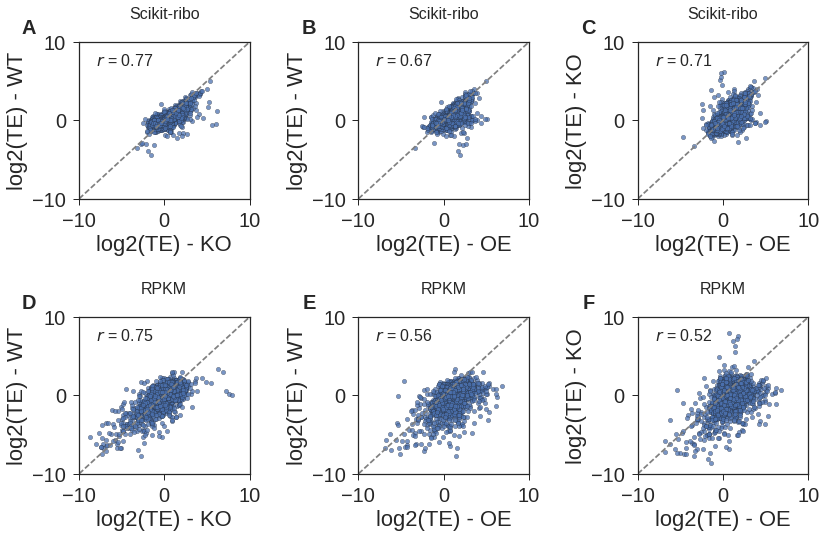

In [154]:
# plot TE correlation
fig = plt.figure(figsize=(12, 8))
i = 0     
for prefix in prefixes:
    for comparison in comparisons:
        fig_idx = strings[i]
        l, r = comparison
        data_prefix = prefix + l + "_VS_" + r
        idx = i + 1
        tool = "Scikit-ribo\n" if prefix == "skr_" else "RPKM\n"
        title = tool + l + " vs. " + r
        df = DFs[data_prefix]
        corr = round(pearsonr(df["log2_TE_" + l], df["log2_TE_" + r])[0], 2)
        ax = plt.subplot(2, 3, idx)
        ax.scatter(x="log2_TE_" + l, y="log2_TE_" + r, data=df, alpha=0.75, edgecolor="k", s=20)
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        ax.text(-8, 7, r"$r$ = " + str(corr) , fontsize=16)
        ax.text(-0.25, 1.15, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
        ax.set_title(tool, fontsize=16)
        ax.set_ylabel('log2(TE) - ' +r)
        ax.set_xlabel("log2(TE) - " +l)
        ax.plot([-10,10], [-10,10], ls="dashed", color='gray')
        i += 1
plt.tight_layout()        
plt.savefig("../Figures/Supplemental/FigureS9_TE_strains.pdf")

Number of genes: 3440
('skr_', ('KO', 'WT'))
Upper & lower bound -0.93685 1.7104
t-test: 3.28157006399e-52
Number of genes: 3529
('skr_', ('OE', 'WT'))
Upper & lower bound -0.80465 2.13255
t-test: 1.53503043502e-51
Number of genes: 3587
('skr_', ('OE', 'KO'))
Upper & lower bound -1.6146 1.74695
t-test: 4.1705867875e-47
Number of genes: 3495
('rpkm_', ('KO', 'WT'))
Upper & lower bound -1.48293398172 1.62899534736
t-test: 2.91185721476e-57
Number of genes: 3590
('rpkm_', ('OE', 'WT'))
Upper & lower bound -1.05148896105 2.43109643166
t-test: 1.14529869924e-57
Number of genes: 3644
('rpkm_', ('OE', 'KO'))
Upper & lower bound -1.74670089773 2.70190236703
t-test: 2.69267480776e-58


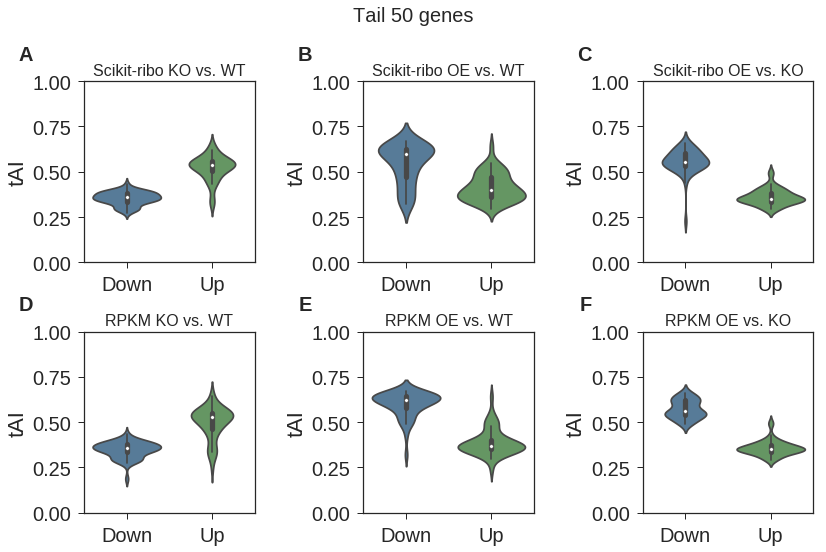

In [155]:
# tail genes comparison
tails_dic = {}
tail = 50
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Tail 50 genes', fontsize=20)

i = 0
for prefix in prefixes:
    for comparison in comparisons:
        idx = i + 1
        fig_idx = strings[i]
        l, r = comparison
        data_prefix = prefix + l + "_VS_" + r
        tmp = DFs[data_prefix].copy()
        tmp = pd.merge(tmp, original, left_on="gene", right_on="Gene")
        tmp = tmp[(tmp[l + "_RNA"] > 10) & (tmp[r + "_RNA"] > 10) & (tmp[l + "_Ribo"] > 10) & (tmp[r + "_Ribo"] > 10)]
        down_tail = tmp.sort_values("deltaTE").head(tail)
        up_tail   = tmp.sort_values("deltaTE", ascending=False).head(tail)
        tails_dic[(prefix, comparison)] = [down_tail, up_tail]
        down_tail[["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_down_50.csv", 
                                   sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        up_tail[["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_up_50.csv", 
                                 sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        # violin tAI in two classes
        down_tail["class"] = "Down"
        up_tail["class"] = "Up"
        tail_combine = pd.concat([down_tail, up_tail])  
        ax = plt.subplot(2, 3, idx)
        sns.violinplot(x="class", y="tAI_x", data=tail_combine, palette=[snsBlue, snsGreen], saturation=1)
        plt.ylabel('tAI') 
        tool = "Scikit-ribo " if prefix == "skr_" else "RPKM "
        title = tool + l + " vs. " + r
        plt.xlabel("")
        ax.set_title(title, fontsize=16)
        plt.ylim(0, 1)
        ax.text(-0.3, 1.2, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
        i+=1
        print("Number of genes: " + str(tmp.shape[0]))
        print(((prefix, comparison)))
        print("Upper & lower bound", down_tail.tail(1)["deltaTE"].values[0], up_tail.tail(1)["deltaTE"].values[0])
        print("t-test:", ttest_ind(down_tail["deltaTE"], up_tail["deltaTE"])[1])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("../Figures/Supplemental/FigureS9_tail50_genes_stAI.pdf")

KO VS WT
15 13
OE VS WT
21 13
OE VS KO
16 11
KO VS WT
15 13
OE VS WT
21 13
OE VS KO
16 11


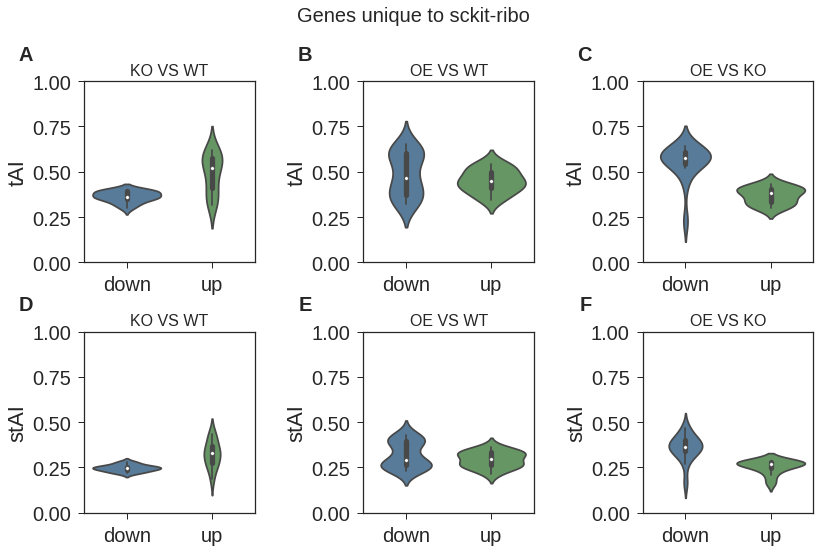

In [156]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Genes unique to sckit-ribo', fontsize=20)

i = 0
for y_axis in ["tAI", "stAI"]:
    for comparison in comparisons:
        idx = i + 1
        fig_idx = strings[i]
        l, r = comparison
        skr_down = set(tails_dic[("skr_", comparison)][0]["gene"])
        rpkm_down = set(tails_dic[("rpkm_", comparison)][0]["gene"])
        skr_up = set(tails_dic[("skr_", comparison)][1]["gene"])
        rpkm_up = set(tails_dic[("rpkm_", comparison)][1]["gene"])
        uniq_down = pd.DataFrame([i for i in skr_down if i not in rpkm_down], columns=["gene"])
        uniq_down = pd.merge(uniq_down, original, left_on='gene', right_on="genes_id")
        uniq_down["class"] = "down"
        uniq_up = pd.DataFrame([i for i in skr_up if i not in rpkm_up], columns=["gene"])
        uniq_up = pd.merge(uniq_up, original, left_on='gene', right_on="genes_id")
        uniq_up["class"] = "up"
        uniqs = pd.concat([uniq_down, uniq_up])
        # plot
        ax = plt.subplot(2, 3, idx)
        sns.violinplot(x="class", y=y_axis, data=uniqs, palette=[snsBlue, snsGreen], saturation=1)
        plt.ylabel(y_axis) 
        plt.title(l + " VS " + r , fontsize=16) 
        ax.text(-0.3, 1.2, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
        plt.xlabel("")
        plt.ylim(0, 1) 
        print( l + " VS " + r )
        print(len(uniq_down), len(uniq_up))
        i += 1 
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("../Figures/Supplemental/FigureS10_unique_genes.pdf")

(143, 11) (288, 11)
(53, 11) (335, 11)
(220, 11) (269, 11)
(143, 11) (288, 11)
(53, 11) (335, 11)
(220, 11) (269, 11)


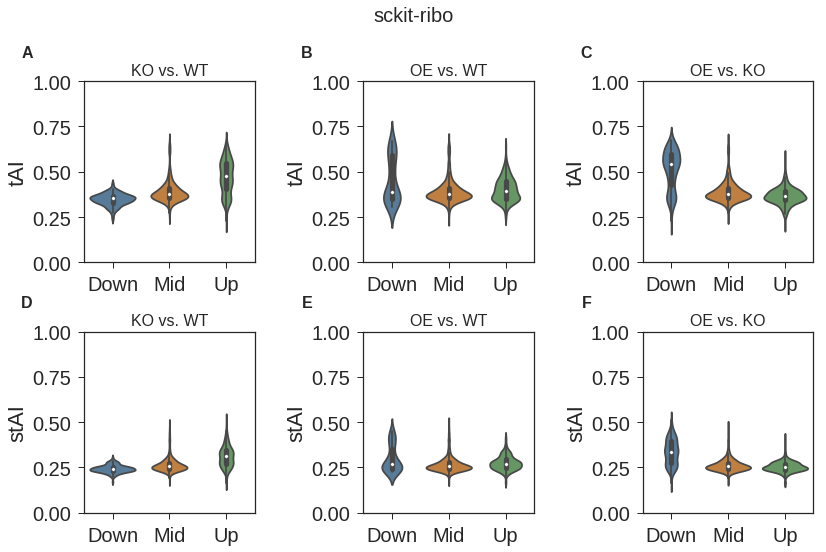

In [157]:
# tAI & stAI in three classes
fig = plt.figure(figsize=(12, 8))
fig.suptitle('sckit-ribo', fontsize=20)
colors = [snsBlue, snsOrange, snsGreen]
prefix="skr_"
i = 0
for y_axis in ["tAI", "stAI"]:
    for comparison in comparisons:
        idx = i + 1
        fig_idx = strings[i]
        l, r = comparison
        data_prefix = prefix + l + "_VS_" + r
        tmp = DFs[data_prefix].copy()
        print(tmp[tmp["deltaTE"] < -deltaTE_cutoff].shape, tmp[tmp["deltaTE"] > deltaTE_cutoff].shape)
        tmp[tmp["deltaTE"] < -deltaTE_cutoff][["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_down.csv", 
                                                               sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        tmp[tmp["deltaTE"] >  deltaTE_cutoff][["gene"]].to_csv(path_or_buf="../Data/Radhakrishnan/" + data_prefix + "_up.csv", 
                                                               sep='\t', header=True, index=False, quoting=csv.QUOTE_NONE) 
        tmp["isDownRegulated"] = np.where(tmp["deltaTE"] < -deltaTE_cutoff, -1, 0) 
        tmp["isUpRegulated"] = np.where(tmp["deltaTE"] > deltaTE_cutoff, 1, 0) 
        tmp["class"] = tmp["isDownRegulated"] + tmp["isUpRegulated"]
        ax = plt.subplot(2, 3, idx)
        sns.violinplot(x="class", y=y_axis, data=tmp, palette=colors, saturation=1)
        plt.ylabel(y_axis) 
        ax.set_xticklabels(["Down", "Mid", "Up"])
        plt.xlabel("")
        # "Down-regulated \n $\Delta$ < -" + str(deltaTE_cutoff), 
        #                      "Mid\n" + "-1<$\Delta$ <1" ,
        #                      "Up-regulated \n $\Delta$ > " + str(deltaTE_cutoff)])
        plt.ylim(0, 1)
        ax.text(-0.3, 1.2, fig_idx, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
        tool = "Scikit-ribo " if prefix == "skr_" else "RPKM "
        plt.title(l + " vs. " + r, fontsize=16) 
        i += 1

plt.tight_layout()             
plt.subplots_adjust(top=0.85)
plt.savefig("../Figures/Supplemental/FigureS13_three_class.pdf")

## 4. Compare codon elongation rates between strains

In [158]:
strains = ["WT", "KO", "OE"]
for strain in strains:
    tmp = DFs["codon_" + strain].copy()
    DFs["codon_" + strain]["dwell_time_" + strain] = (tmp["codon_dwell_time_rep1"] + tmp["codon_dwell_time_rep2"]) / 2
    print("s.d.: ",  strain, np.std(DFs["codon_" + strain]["dwell_time_" + strain]))

s.d.:  WT 0.3640642034468501
s.d.:  KO 0.4534280328292334
s.d.:  OE 0.2729516429269326


In [159]:
codon_all_strains = pd.merge(DFs["codon_WT"], DFs["codon_KO"], on="codon")
codon_all_strains = pd.merge(codon_all_strains, DFs["codon_OE"], on="codon")

codon_all_strains = pd.merge(codon_all_strains, DFs[codon_stAI], on="codon")
codon_all_strains = pd.merge(codon_all_strains, DFs[codon_tAI], on="codon")
codon_all_strains['dwell_time_WT_rank'] = codon_all_strains['dwell_time_WT'].rank(ascending=1) # top is fast

In [160]:
codon_all_strains["log2_ratio_DT_OE_VS_WT"] = np.log2(codon_all_strains["dwell_time_OE"] / codon_all_strains["dwell_time_WT"])
codon_all_strains["log2_ratio_DT_KO_VS_WT"] = np.log2(codon_all_strains["dwell_time_KO"] / codon_all_strains["dwell_time_WT"])
codon_all_strains["log2_ratio_DT_OE_VS_KO"] = np.log2(codon_all_strains["dwell_time_OE"] / codon_all_strains["dwell_time_KO"])

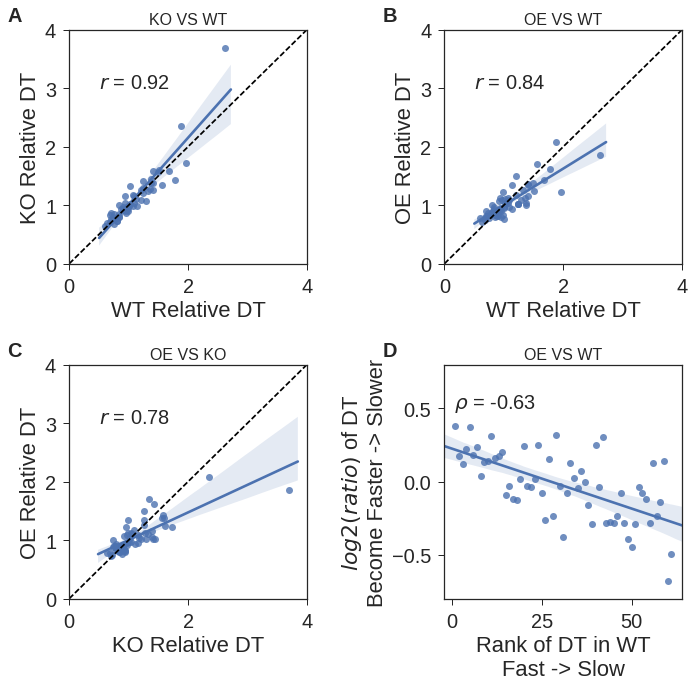

In [161]:
comparisons = [("KO", "WT"), ("OE", "WT"), ("OE", "KO")] 

fig = plt.figure(figsize=(10, 10))

i = 0
for comparison in comparisons:
    l, r = comparison
    fig_idx = strings[i]
    idx = i + 1
    ax = plt.subplot(2, 2, idx)
    corr = round(pearsonr(codon_all_strains["dwell_time_" + l], codon_all_strains["dwell_time_" + r])[0], 2)
    sns.regplot(x="dwell_time_" + r, y="dwell_time_" + l, data=codon_all_strains) 
    ax.set_ylabel(l + ' Relative DT')
    ax.set_xlabel(r + " Relative DT")
    ax.set(ylim=(0, 4))
    ax.set(xlim=(0, 4))
    ax.text(-0.2, 1.1, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax.text(0.5, 3, r"$r$ = " + str(corr) , fontsize=20)
    plt.title(l + " VS " + r , fontsize=16) 
    plt.plot([0, 4], [0, 4], ls="dashed", color='black')
    i += 1

ax = plt.subplot(2, 2, 4)
sns.regplot(x="dwell_time_WT_rank", y="log2_ratio_DT_OE_VS_WT", data=codon_all_strains) 
corr = round(spearmanr(codon_all_strains["log2_ratio_DT_OE_VS_WT"], codon_all_strains["dwell_time_WT_rank"])[0], 2)
ax.text(0.5, 0.5, r"$\rho$ = " + str(corr) , fontsize=20)
ax.set(ylim=(-0.8, 0.8))
ax.set_ylabel('$log2(ratio)$ of DT\nBecome Faster -> Slower')
ax.set_xlabel("Rank of DT in WT\nFast -> Slow")
ax.text(-0.2, 1.1, "D", transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
plt.title("OE VS WT" , fontsize=16) 

plt.tight_layout()
plt.savefig("../Figures/Supplemental/FigureS12_codon_corr_strains.pdf")
plt.show()

#### Different from original paper

In [162]:
colNames = ["codon", "dwell_time_WT", "dwell_time_KO", "dwell_time_OE", "tAI", "dwell_time_WT_rank",
            "log2_ratio_DT_OE_VS_WT", "log2_ratio_DT_KO_VS_WT", "log2_ratio_DT_OE_VS_KO"]
codon_all_strains[colNames].sort_values("dwell_time_WT_rank").to_csv(path_or_buf="../Data/TableS1_codon_DT_strains.csv", 
                                   sep=',', header=True, index=False, quoting=csv.QUOTE_NONE)

In [163]:
codon_all_strains[codon_all_strains["log2_ratio_DT_OE_VS_WT"] < -0.3].sort_values("log2_ratio_DT_OE_VS_WT")

,codon,codon_dwell_time_rep1_x,codon_dwell_time_rep2_x,dwell_time_WT,codon_dwell_time_rep1_y,codon_dwell_time_rep2_y,dwell_time_KO,codon_dwell_time_rep1,codon_dwell_time_rep2,dwell_time_OE,stAI,tAI,dwell_time_WT_rank,log2_ratio_DT_OE_VS_WT,log2_ratio_DT_KO_VS_WT,log2_ratio_DT_OE_VS_KO
21,CCC,2.0917,1.8245,1.95810,1.7545,1.6922,1.72335,1.1827,1.2618,1.22225,0.219,0.089,60.0,-0.679915,-0.184239,-0.495676
22,CCG,2.9446,2.2907,2.61765,4.0101,3.3741,3.69210,1.8879,1.8222,1.85505,0.393,0.197,61.0,-0.496814,0.496169,-0.992984
20,CCA,1.4278,1.3273,1.37755,1.4522,1.4339,1.44305,0.9871,1.0347,1.01090,0.518,0.616,50.0,-0.446464,0.067017,-0.513481
23,CCT,1.4351,1.3085,1.37180,1.4095,1.3593,1.38440,1.0318,1.0589,1.04535,0.104,0.123,49.0,-0.392084,0.013191,-0.405275
39,GCT,1.0000,0.9914,0.99570,0.8729,0.9108,0.89185,0.7607,0.7706,0.76565,0.569,0.677,31.0,-0.379026,-0.158910,-0.220116


In [164]:
codon_all_strains[codon_all_strains["log2_ratio_DT_OE_VS_WT"] > 0.3].sort_values("log2_ratio_DT_OE_VS_WT")

,codon,codon_dwell_time_rep1_x,codon_dwell_time_rep2_x,dwell_time_WT,codon_dwell_time_rep1_y,codon_dwell_time_rep2_y,dwell_time_KO,codon_dwell_time_rep1,codon_dwell_time_rep2,dwell_time_OE,stAI,tAI,dwell_time_WT_rank,log2_ratio_DT_OE_VS_WT,log2_ratio_DT_KO_VS_WT,log2_ratio_DT_OE_VS_KO
29,CTC,1.1620,1.2444,1.2032,1.2312,1.2890,1.26010,1.5491,1.4305,1.48980,0.052,0.062,42.0,0.308242,0.066662,0.241580
56,TGT,0.7988,0.8086,0.8037,0.7311,0.7253,0.72820,1.0293,0.9629,0.99610,0.028,0.108,11.0,0.309634,-0.142322,0.451956
31,CTT,0.9515,1.0225,0.9870,0.9286,0.9807,0.95465,1.2859,1.1718,1.22885,0.007,0.027,29.0,0.316187,-0.048078,0.364265
57,TTA,0.6449,0.7471,0.6960,0.7337,0.7792,0.75645,0.9081,0.8940,0.90105,0.362,0.431,5.0,0.372520,0.120157,0.252362
19,CAT,0.5709,0.6389,0.6049,0.6541,0.6248,0.63945,0.8077,0.7672,0.78745,0.048,0.189,1.0,0.380492,0.080135,0.300357


In [165]:
print("AGG", codon_all_strains[codon_all_strains["codon"] == "AGG"]["log2_ratio_DT_OE_VS_WT"])

AGG 10   -0.038657
Name: log2_ratio_DT_OE_VS_WT, dtype: float64


In [166]:
# purine ribonucleoside triphosphate metabolic process [GO:0009205]
KO_VS_WT_Up_GO_genes = pd.DataFrame(["YBL099W", "YFR053C", "YJL052W", "YKL016C",
                                     "YLR134W", "YML056C", "YMR256C", "YOR065W"], columns=["gene"])
# translational elongation [GO:0006414]
OE_VS_WT_Down_GO_genes = pd.DataFrame(["YAL003W", "YBR048W", "YCR031C", "YDL075W", "YDL082W", "YDL083C", "YDL160C", 
                                       "YDL229W","YDR025W", "YDR450W", "YER074W", "YGR214W", "YIL069C", "YJR047C", 
                                       "YKR094C", "YLL045C","YLR048W", "YLR406C", "YMR116C", "YMR143W", "YNL301C", 
                                       "YOR096W", "YPL198W"], columns=["gene"])
# ATP metabolic process [GO:0046034]
OE_VS_WT_Up_GO_genes = pd.DataFrame(["YDR377W", "YFR053C", "YGL191W", "YGR183C", 
                                     "YJL166W", "YKL016C", "YMR256C", "YNL052W"], columns=["gene"]) 

In [167]:
KO_VS_WT_Up_GO_genes["class"] = "Up - KO"
OE_VS_WT_Down_GO_genes["class"] = "Down - OE"
OE_VS_WT_Up_GO_genes["class"] = "UP - OE"

KO_VS_WT_Up_GO_genes = pd.merge(KO_VS_WT_Up_GO_genes, DFs[gene_tAI], left_on="gene", right_on="genes_id")
OE_VS_WT_Down_GO_genes = pd.merge(OE_VS_WT_Down_GO_genes, DFs[gene_tAI], left_on="gene", right_on="genes_id")
OE_VS_WT_Up_GO_genes = pd.merge(OE_VS_WT_Up_GO_genes, DFs[gene_tAI], left_on="gene", right_on="genes_id")
GO_genes = pd.concat([KO_VS_WT_Up_GO_genes, OE_VS_WT_Down_GO_genes, OE_VS_WT_Up_GO_genes])

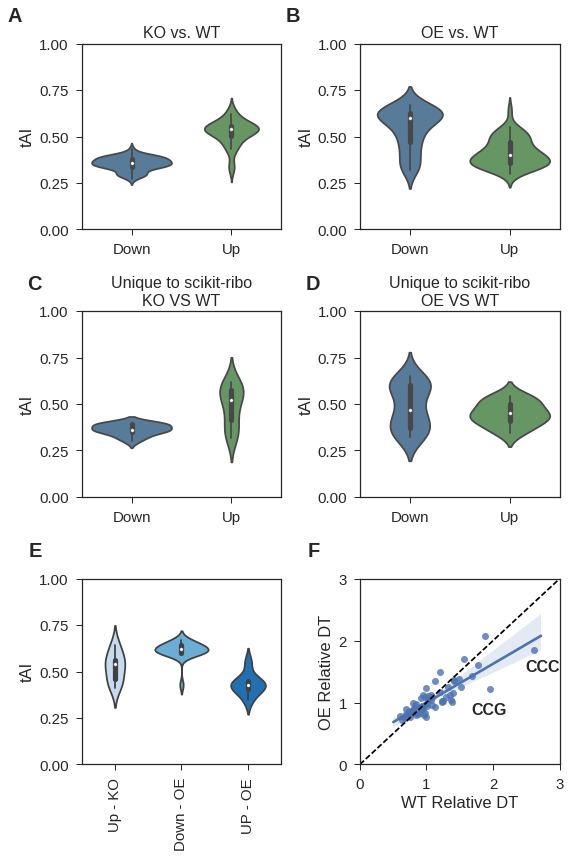

In [168]:
sns.set(style="ticks", color_codes=True,font_scale=1.5)

fig = plt.figure(figsize=(8, 12))

main_comparisons = [("KO", "WT"), ("OE", "WT")] 

i = 0
for comparison in main_comparisons:
    idx = i + 1
    fig_idx = strings[i]
    l, r = comparison
    data_prefix = prefix + l + "_VS_" + r
    tmp = DFs[data_prefix].copy()
    tmp = pd.merge(tmp, original, left_on="gene", right_on="Gene")
    tmp = tmp[(tmp[l + "_RNA"] > 10) & (tmp[r + "_RNA"] > 10) & (tmp[l + "_Ribo"] > 10) & (tmp[r + "_Ribo"] > 10)]
    down_tail = tmp.sort_values("deltaTE").head(tail)
    up_tail   = tmp.sort_values("deltaTE", ascending=False).head(tail)
    # violin tAI in two classes
    down_tail["class"] = "Down"
    up_tail["class"] = "Up"
    tail_combine = pd.concat([down_tail, up_tail])  
    ax = plt.subplot(3, 2, idx)
    sns.violinplot(x="class", y="tAI_x", data=tail_combine, palette=[snsBlue, snsGreen], saturation=1)
    plt.ylabel('tAI') 
    title = l + " vs. " + r
    plt.xlabel("")
    ax.set_title(title, fontsize=16)
    plt.ylim(0, 1)
    ax.text(-0.3, 1.2, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    i += 1

for comparison in main_comparisons:
    idx = i + 1
    fig_idx = strings[i]
    l, r = comparison
    skr_down = set(tails_dic[("skr_", comparison)][0]["gene"])
    rpkm_down = set(tails_dic[("rpkm_", comparison)][0]["gene"])
    skr_up = set(tails_dic[("skr_", comparison)][1]["gene"])
    rpkm_up = set(tails_dic[("rpkm_", comparison)][1]["gene"])
    uniq_down = pd.DataFrame([i for i in skr_down if i not in rpkm_down], columns=["gene"])
    uniq_down = pd.merge(uniq_down, original, left_on='gene', right_on="genes_id")
    uniq_down["class"] = "Down"
    uniq_up = pd.DataFrame([i for i in skr_up if i not in rpkm_up], columns=["gene"])
    uniq_up = pd.merge(uniq_up, original, left_on='gene', right_on="genes_id")
    uniq_up["class"] = "Up"
    uniqs = pd.concat([uniq_down, uniq_up])
    # plot
    ax = plt.subplot(3, 2, idx)
    sns.violinplot(x="class", y="tAI", data=uniqs, palette=[snsBlue, snsGreen], saturation=1)
    plt.ylabel("tAI") 
    plt.title("Unique to scikit-ribo\n" + l + " VS " + r , fontsize=16) 
    ax.text(-0.2, 1.2, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    plt.xlabel("")
    plt.ylim(0, 1) 
    i += 1 

# GO genes
fig_idx = strings[i]
idx = i + 1
ax = plt.subplot(3, 2, idx)
g= sns.violinplot(x="class", y="tAI", data=GO_genes, palette="Blues", saturation=1)
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.xlabel("")
ax.text(-0.2, 1.2, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
i += 1
    
# codon
l, r = ("OE", "WT")
fig_idx = strings[i]
idx = i + 1
ax = plt.subplot(3, 2, idx)
sns.regplot(x="dwell_time_" + r, y="dwell_time_" + l, data=codon_all_strains) 
ax.set_ylabel(l + ' Relative DT')
ax.set_xlabel(r + " Relative DT")
ax.set(ylim=(0, 3))
ax.set(xlim=(0, 3))
ax.text(-0.2, 1.2, fig_idx, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
ax.text(2.2, 1, "CCG", fontsize=16, fontweight='bold', va='top', ha='right')
ax.text(3, 1.7, "CCC", fontsize=16, fontweight='bold', va='top', ha='right')
plt.plot([0, 3], [0, 3], ls="dashed", color='black')
i += 1
    
plt.tight_layout()
plt.savefig("../Figures/Figure6_Dhh1p.pdf")
sns.set(style="ticks", color_codes=True,font_scale=2)
